## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 23.4,
 5: 24.9,
 10: 25.6,
 20: 26.6,
 30: 27.4,
 40: 28.7,
 50: 30.3,
 60: 32.1,
 70: 34.0,
 80: 36.5,
 90: 40.0,
 95: 43.0,
 99: 49.10200000000005}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.7,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=4.37, lognorm_sd=1.93, norm_mean=1.39, norm_sd=0.42)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=12.12, lognorm_sd=9.64, norm_mean=2.25, norm_sd=0.7)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lo

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(1.5, 3.5),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 23),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1, 4.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.94, 1.02, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1106676.52it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.0004,
 60: 0.0005,
 70: 0.00068,
 80: 0.00103,
 90: 0.00216,
 95: 0.00387,
 99: 0.00959}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.0e+09',
 50: '9.1e+09',
 60: '1.2e+10',
 70: '1.6e+10',
 80: '2.4e+10',
 90: '5.0e+10',
 95: '8.9e+10',
 99: '2.2e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 31.6 log FLOP (~40 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~26 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~124 million). This doubles every 2.3 years to a max of 0.040639% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.4 max log FLOP (245 septillion) available - TAI takes 31.6 log FLOP (40 nonillion) - log $ 13.3 to buy TAI (20 trillion) vs. willingness to pay log $ 8.1 (123 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (439 septillion) available - TAI takes 31.5 log FLOP (31 nonillion) - log $ 13.1 to buy TAI (12 trillion) vs. willingness to pay log $ 8.2 (166 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFL

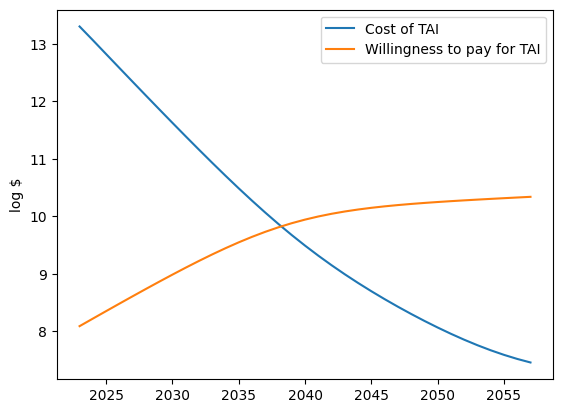

-
-
## SAMPLE RUN 2 ##
It takes 32.4 log FLOP (~251 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 32.4 log FLOP (251 nonillion) - log $ 14.1 to buy TAI (126 trillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 32.3 log FLOP (180 nonillion) - log $ 13.9 to buy TAI (72 trillion) vs. willingness to pay log $ 8.7 (544 million) - 18.4 log FLOP 

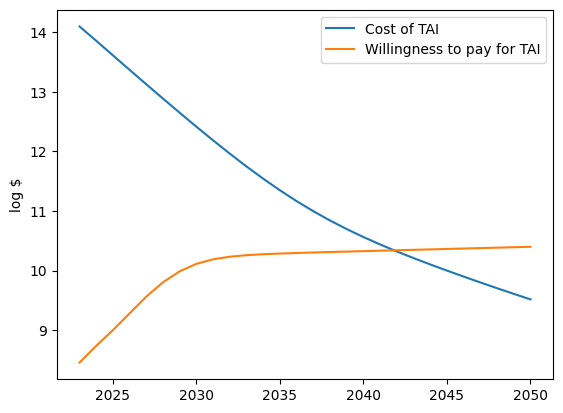

-
-
## SAMPLE RUN 3 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 1.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.9 to buy TAI (79 million) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 8 years)
-- data p_nonscal

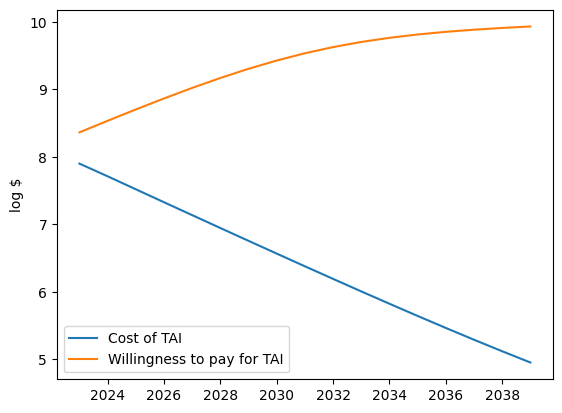

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.51it/s]


Shuffling data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 194.69it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2033',
 '10%: 2035',
 '15%: 2036',
 '20%: 2037',
 '25%: 2038',
 '35%: 2041',
 '50%: 2046',
 '60%: 2052',
 '75%: 2072',
 '80%: 2102',
 '90%: >2123',
 '95%: >2123']
(Mean: 2062)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 10 years from now',
 '10%: 12 years from now',
 '15%: 13 years from now',
 '20%: 14 years from now',
 '25%: 15 years from now',
 '35%: 18 years from now',
 '50%: 23 years from now',
 '60%: 29 years from now',
 '75%: 49 years from now',
 '80%: 79 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 39 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.1%
2028-2029: 0.9%
2030-2034: 7.8%
2035-2039: 20.2%
2040-2049: 27.7%
2050-2059: 12.3%
2060-2069: 5.2%
2070-2079: 2.8%
2080-2089: 1.9%
2090-2099: 1.0%
2100-2109: 0.

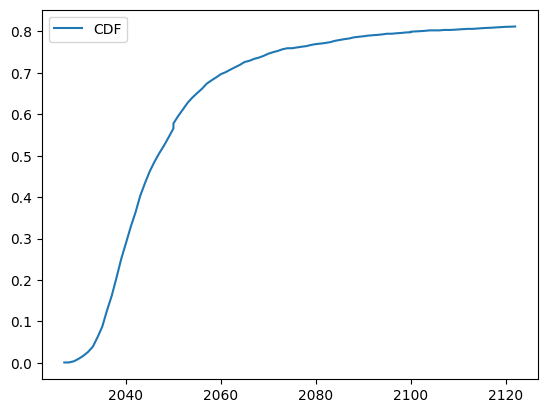

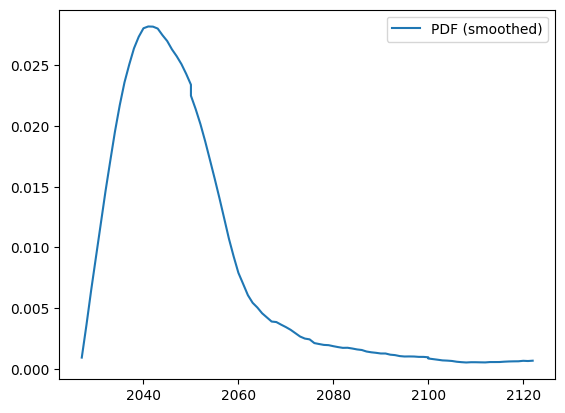

-
-
## TAI FLOP SIZE ##
{1: 23.0,
 5: 24.7,
 10: 25.4,
 20: 26.4,
 30: 27.2,
 40: 28.5,
 50: 30.1,
 60: 31.9,
 70: 33.6,
 80: 36.1,
 90: 39.6,
 95: 42.6,
 99: 47.9}
(Mean: 31.5)


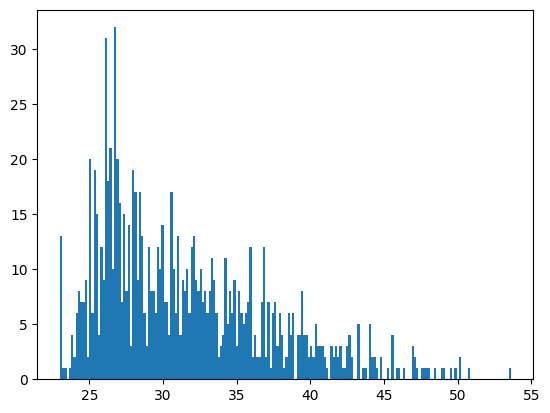

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 23.1,
 5: 15.9,
 10: 12.9,
 20: 10.5,
 30: 8.6,
 40: 7.7,
 50: 6.7,
 60: 5.9,
 70: 5.2,
 80: 4.5,
 90: 3.6,
 95: 3.1,
 99: 2.1}
(Mean: 7.7)


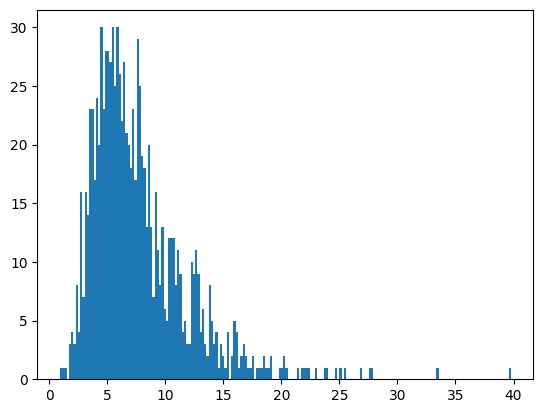

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.9,
 5: 3.5,
 10: 3.3,
 20: 3.0,
 30: 2.9,
 40: 2.7,
 50: 2.5,
 60: 2.4,
 70: 2.2,
 80: 2.0,
 90: 1.8,
 95: 1.5,
 99: 1.2}
(Mean: 2.5)


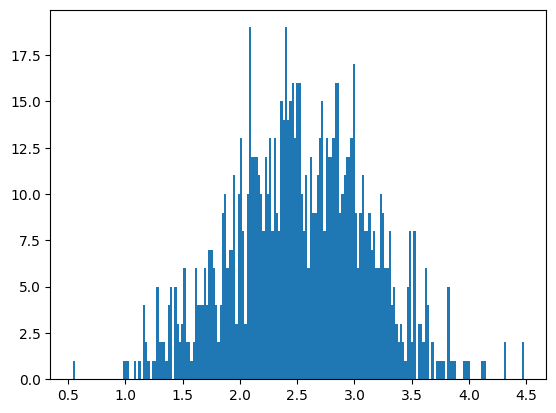

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.7,
 5: 21.0,
 10: 21.2,
 20: 21.4,
 30: 21.6,
 40: 21.8,
 50: 22.0,
 60: 22.1,
 70: 22.3,
 80: 22.5,
 90: 22.8,
 95: 23.1,
 99: 23.5}
(Mean: 22.0)


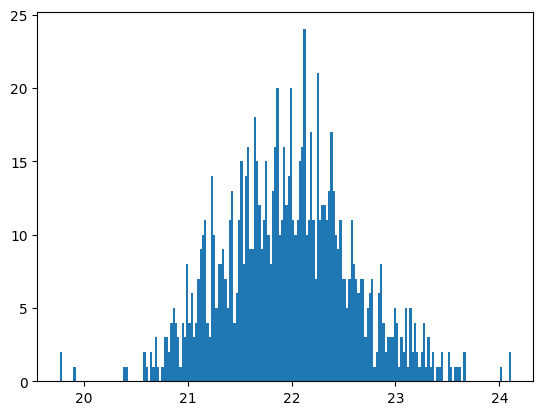

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.7,
 60: 8.8,
 70: 8.8,
 80: 9.0,
 90: 9.1,
 95: 9.3,
 99: 9.7}
(Mean: 8.7)


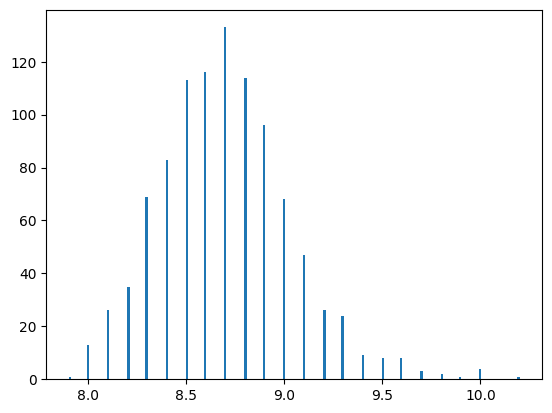

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}
(Mean: 1.0)


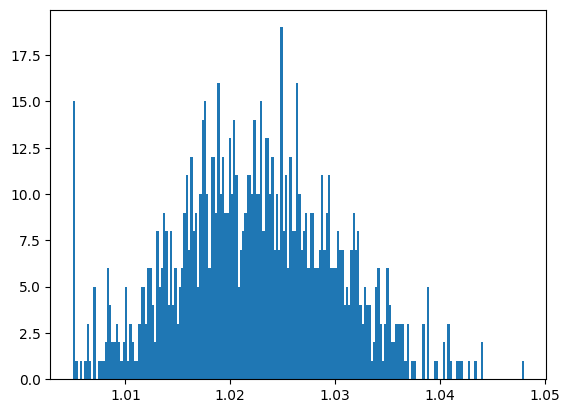

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00038,
 60: 0.00048,
 70: 0.00066,
 80: 0.00094,
 90: 0.00188,
 95: 0.00335,
 99: 0.00892}
(Mean: 0.0)


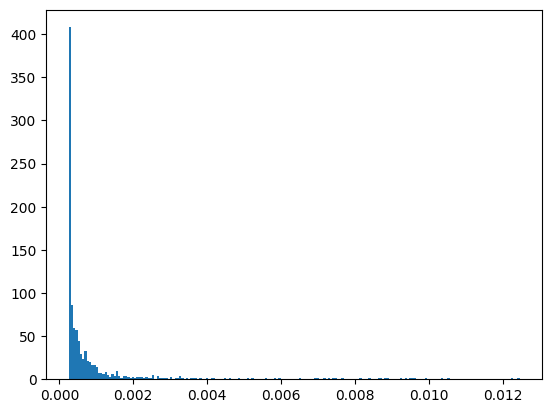

-
-
## SPEND DOUBLING TIME ##
{1: 5.2,
 5: 4.4,
 10: 4.1,
 20: 3.6,
 30: 3.3,
 40: 3.0,
 50: 2.7,
 60: 2.4,
 70: 2.1,
 80: 1.8,
 90: 1.4,
 95: 1.0,
 99: 0.9}
(Mean: 2.7)


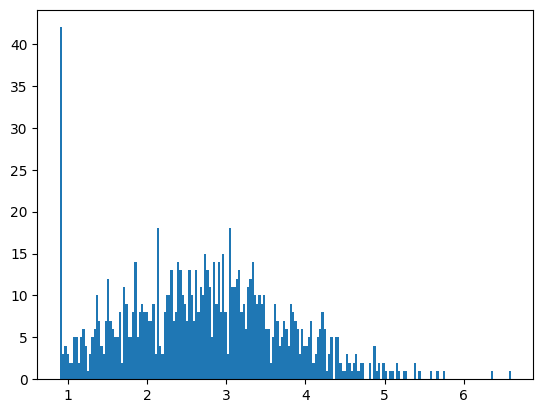

-
-
-
-
## GDP Over Time ##


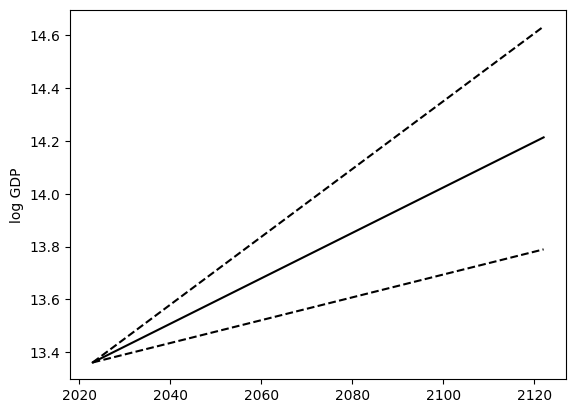

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

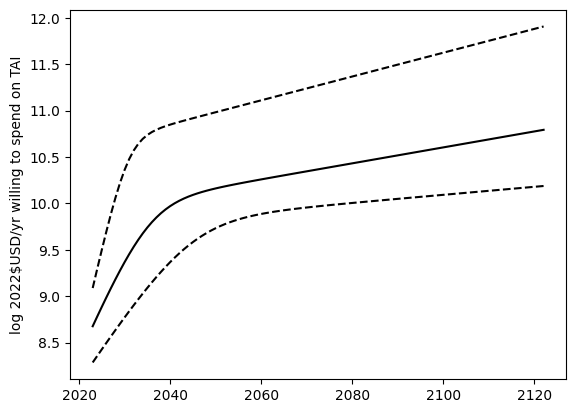

Year: 2023 - willingness log 2022$USD per year 8.7 (~474 million) 90% CI 8.3 (~193 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.8 (~604 million) 90% CI 8.4 (~227 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.9 (~767 million) 90% CI 8.4 (~267 million) - 9.5 (~3 billion)
Year: 2026 - willingness log 2022$USD per year 9.0 (~969 million) 90% CI 8.5 (~314 million) - 9.7 (~5 billion)
Year: 2027 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.6 (~368 million) - 9.9 (~8 billion)
Year: 2028 - willingness log 2022$USD per year 9.2 (~2 billion) 90% CI 8.6 (~431 million) - 10.1 (~12 billion)
Year: 2029 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.7 (~505 million) - 10.2 (~17 billion)
Year: 2030 - willingness log 2022$USD per year 9.4 (~2 billion) 90% CI 8.8 (~589 million) - 10.4 (~23 billion)
Year: 2031 - willingness log 2022$USD per year 9.5 (~3 billion) 90% CI 8.8 (~687 million) - 10.5 (~30 billion)
Yea

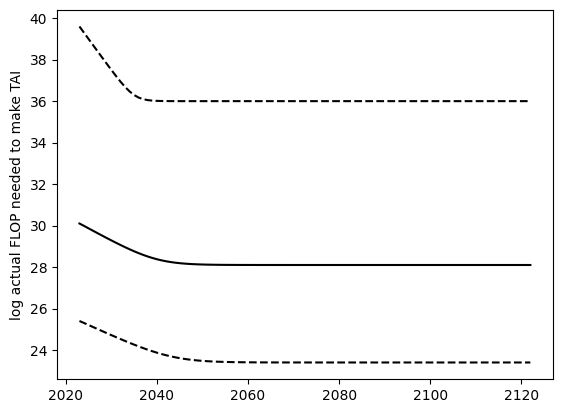

Year: 2023 - log FLOP needed for TAI 30.1 (~1 nonillion) 90% CI 25.4 (~25 septillion) - 39.6 (~4 million decillion)
Year: 2024 - log FLOP needed for TAI 30.0 (~967 octillion) 90% CI 25.3 (~20 septillion) - 39.3 (~2 million decillion)
Year: 2025 - log FLOP needed for TAI 29.9 (~736 octillion) 90% CI 25.2 (~16 septillion) - 39.0 (~996 thousand decillion)
Year: 2026 - log FLOP needed for TAI 29.7 (~561 octillion) 90% CI 25.1 (~13 septillion) - 38.7 (~499 thousand decillion)
Year: 2027 - log FLOP needed for TAI 29.6 (~428 octillion) 90% CI 25.0 (~10 septillion) - 38.4 (~250 thousand decillion)
Year: 2028 - log FLOP needed for TAI 29.5 (~327 octillion) 90% CI 24.9 (~8 septillion) - 38.1 (~125 thousand decillion)
Year: 2029 - log FLOP needed for TAI 29.4 (~251 octillion) 90% CI 24.8 (~7 septillion) - 37.8 (~63 thousand decillion)
Year: 2030 - log FLOP needed for TAI 29.3 (~193 octillion) 90% CI 24.7 (~5 septillion) - 37.5 (~32 thousand decillion)
Year: 2031 - log FLOP needed for TAI 29.2 (~1

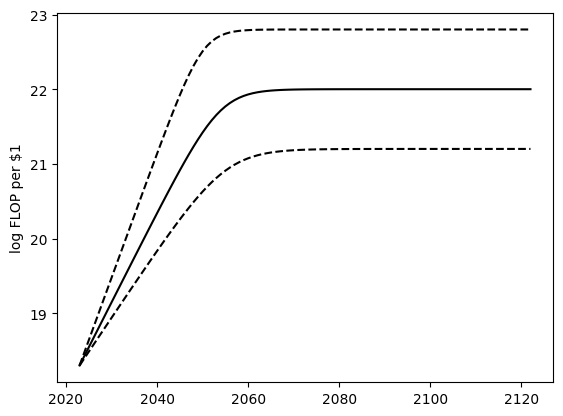

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~2 quintillion) - 18.5 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.6 (~4 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.8 (~6 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 19.0 (~9 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~6 quintillion) - 19.1 (~14 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.8 (~7 quintillion) - 19.3 (~20 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 18.9 (~9 quintillion) - 19.5 (~30 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.0 (~11 quintillion) - 19.6 (~43 quinti

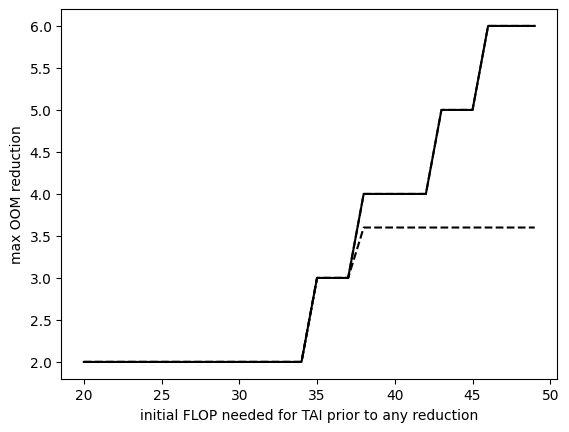

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

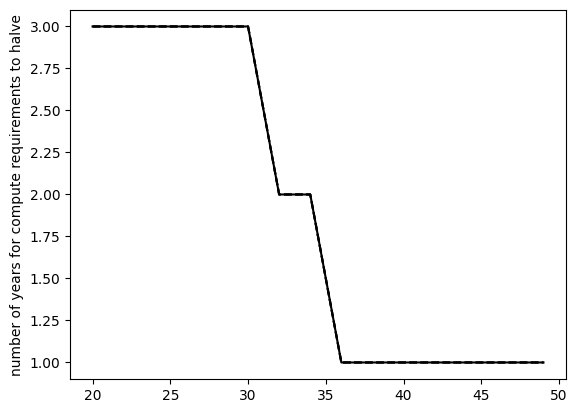

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

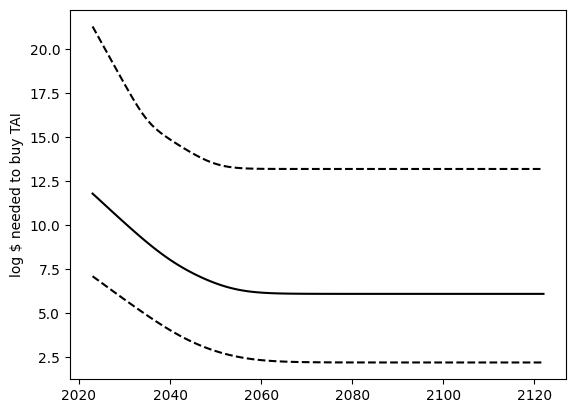

Year: 2023 - 11.8 log 2022$USD to buy TAI (~631 billion) 90% CI 7.1 (~13 million) - 21.3 (~2 sextillion)
Year: 2024 - 11.6 log 2022$USD to buy TAI (~367 billion) 90% CI 6.9 (~8 million) - 20.8 (~679 quintillion)
Year: 2025 - 11.3 log 2022$USD to buy TAI (~212 billion) 90% CI 6.7 (~5 million) - 20.4 (~231 quintillion)
Year: 2026 - 11.1 log 2022$USD to buy TAI (~122 billion) 90% CI 6.5 (~3 million) - 19.9 (~79 quintillion)
Year: 2027 - 10.8 log 2022$USD to buy TAI (~71 billion) 90% CI 6.3 (~2 million) - 19.4 (~27 quintillion)
Year: 2028 - 10.6 log 2022$USD to buy TAI (~41 billion) 90% CI 6.2 (~1 million) - 19.0 (~9 quintillion)
Year: 2029 - 10.4 log 2022$USD to buy TAI (~24 billion) 90% CI 6.0 (~932 thousand) - 18.5 (~3 quintillion)
Year: 2030 - 10.1 log 2022$USD to buy TAI (~14 billion) 90% CI 5.8 (~606 thousand) - 18.0 (~1 quintillion)
Year: 2031 - 9.9 log 2022$USD to buy TAI (~8 billion) 90% CI 5.6 (~395 thousand) - 17.6 (~381 quadrillion)
Year: 2032 - 9.7 log 2022$USD to buy TAI (~5 

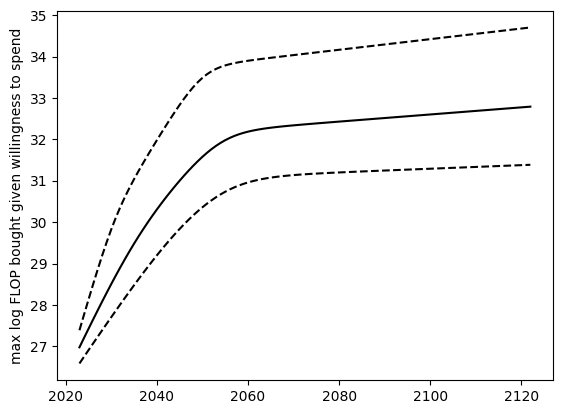

Year: 2023 - max log FLOP 27.0 (~946 septillion) 90% CI 26.6 (~384 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log FLOP 27.2 (~2 octillion) 90% CI 26.7 (~558 septillion) - 27.8 (~6 octillion)
Year: 2025 - max log FLOP 27.4 (~3 octillion) 90% CI 26.9 (~810 septillion) - 28.1 (~14 octillion)
Year: 2026 - max log FLOP 27.6 (~4 octillion) 90% CI 27.1 (~1 octillion) - 28.5 (~32 octillion)
Year: 2027 - max log FLOP 27.9 (~7 octillion) 90% CI 27.2 (~2 octillion) - 28.9 (~72 octillion)
Year: 2028 - max log FLOP 28.1 (~12 octillion) 90% CI 27.4 (~2 octillion) - 29.2 (~158 octillion)
Year: 2029 - max log FLOP 28.3 (~20 octillion) 90% CI 27.5 (~4 octillion) - 29.5 (~335 octillion)
Year: 2030 - max log FLOP 28.5 (~32 octillion) 90% CI 27.7 (~5 octillion) - 29.8 (~677 octillion)
Year: 2031 - max log FLOP 28.7 (~52 octillion) 90% CI 27.9 (~7 octillion) - 30.1 (~1 nonillion)
Year: 2032 - max log FLOP 28.9 (~82 octillion) 90% CI 28.0 (~10 octillion) - 30.4 (~2 nonillion)
Year: 2033 - max log FL

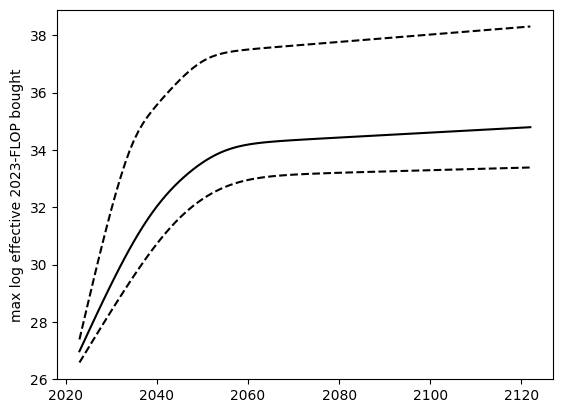

Year: 2023 - max log effective 2023-FLOP 27.0 (~946 septillion) 90% CI 26.6 (~384 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log effective 2023-FLOP 27.3 (~2 octillion) 90% CI 26.8 (~694 septillion) - 28.1 (~12 octillion)
Year: 2025 - max log effective 2023-FLOP 27.7 (~5 octillion) 90% CI 27.1 (~1 octillion) - 28.7 (~54 octillion)
Year: 2026 - max log effective 2023-FLOP 28.0 (~10 octillion) 90% CI 27.4 (~2 octillion) - 29.4 (~252 octillion)
Year: 2027 - max log effective 2023-FLOP 28.3 (~22 octillion) 90% CI 27.6 (~4 octillion) - 30.1 (~1 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.7 (~47 octillion) 90% CI 27.9 (~8 octillion) - 30.7 (~5 nonillion)
Year: 2029 - max log effective 2023-FLOP 29.0 (~100 octillion) 90% CI 28.1 (~14 octillion) - 31.3 (~21 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.3 (~210 octillion) 90% CI 28.4 (~24 octillion) - 31.9 (~84 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.6 (~436 octillion) 90% CI 28.6 (~44 octillion) - 32.

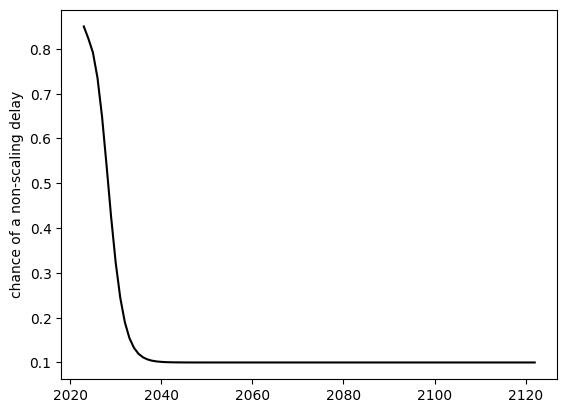

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 82%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 79%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 74%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 65%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 54%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2033

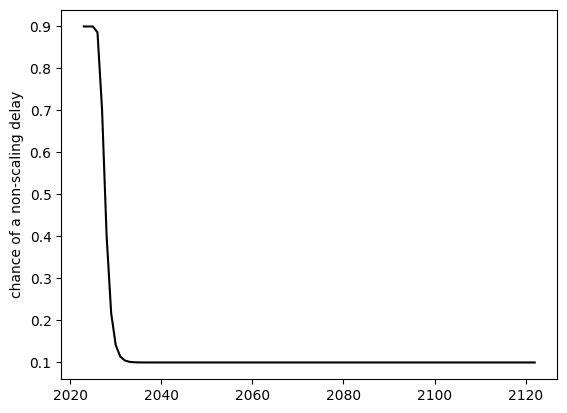

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

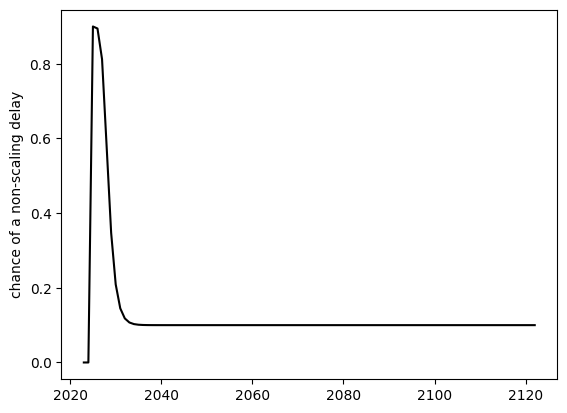

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 81%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2033 -

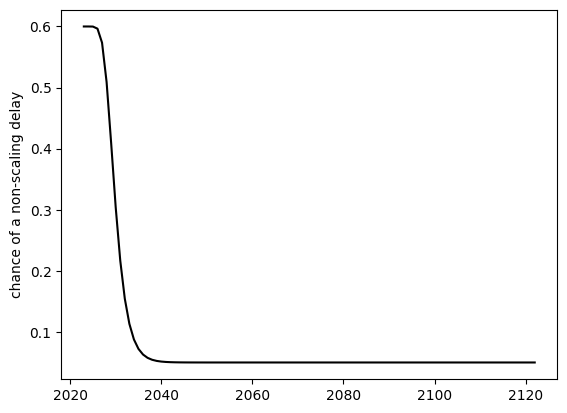

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 51%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2033

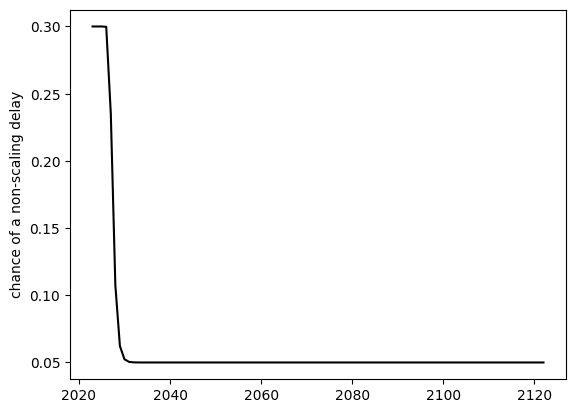

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - c

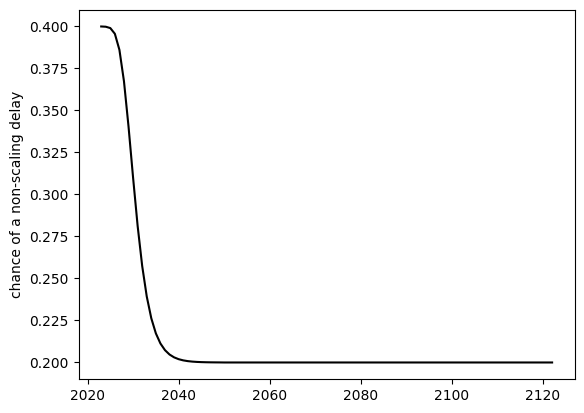

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2033

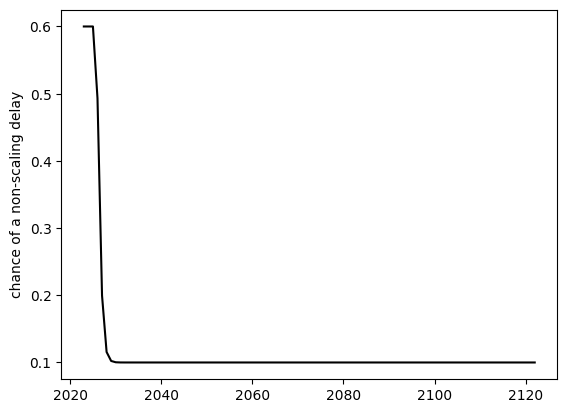

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

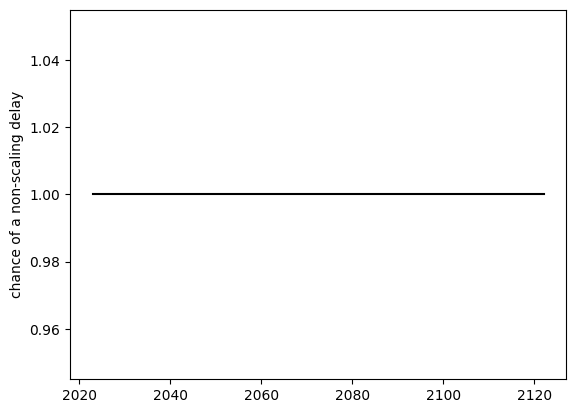

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%


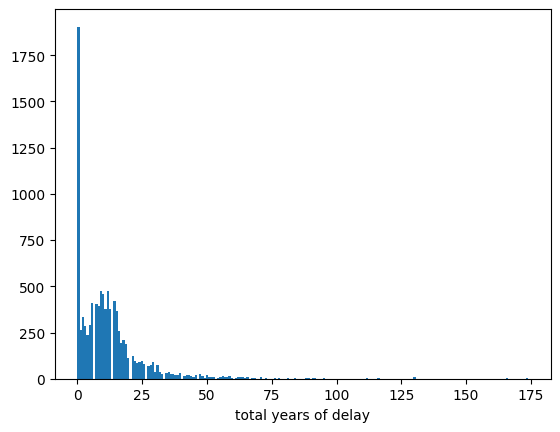

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 23.9 log FLOP (~794 sextillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~388 million). This doubles every 2.8 years to a max of 0.066987% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.9 max log FLOP (755 septillion) available - TAI takes 23.9 log FLOP (794 sextillion) - log $ 5.6 to buy TAI (398 thousand) vs. willingness to pay log $ 8.6 (379 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 6 years)
-- data p_no

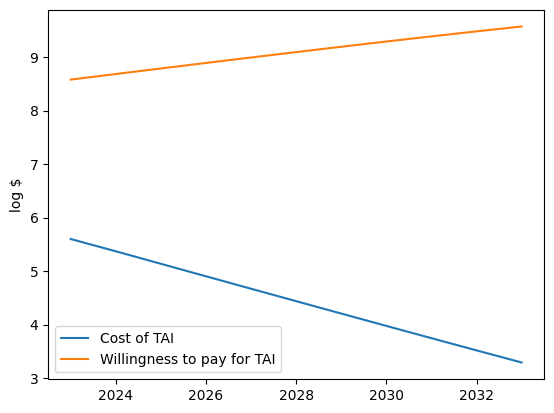

-
-
## SAMPLE RUN 5 ##
It takes 27.7 log FLOP (~5 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~87 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 2.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.4 to buy TAI (3 billion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (490 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.3 (196 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.8)
Year

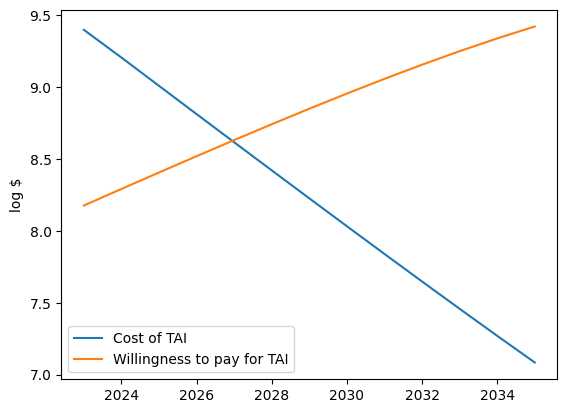

-
-
## SAMPLE RUN 6 ##
It takes 25.8 log FLOP (~63 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~22 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~736 million). This doubles every 1.2 years to a max of 0.043973% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 25.8 log FLOP (63 septillion) - log $ 7.5 to buy TAI (32 million) vs. willingness to pay log $ 8.8 (686 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 8 years)
-- data p_nonscali

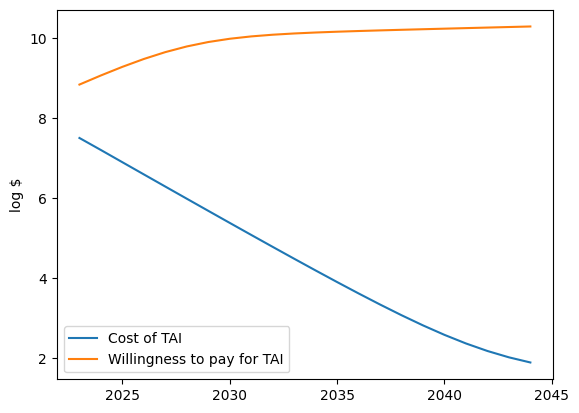

-
-
## SAMPLE RUN 7 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 2.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.7 to buy TAI (502 million) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (650 septillion) available - TAI takes 26.9 log FLOP (804 septillion) - log $ 8.5 to buy TAI (303 million) vs. willingness to pay log $ 8.4 (245 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.9

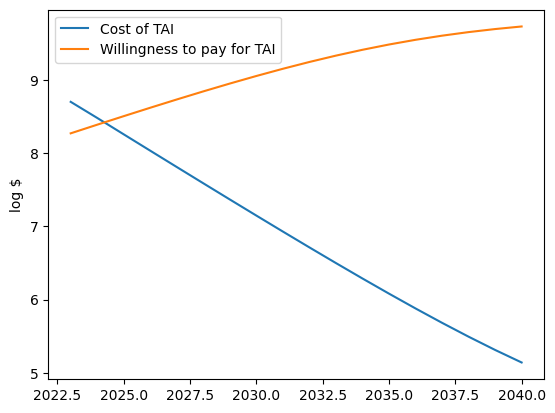

-
-
## SAMPLE RUN 8 ##
It takes 25.2 log FLOP (~16 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.4 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~386 million). This doubles every 3.9 years to a max of 0.054446% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.9 max log FLOP (747 septillion) available - TAI takes 25.2 log FLOP (16 septillion) - log $ 6.9 to buy TAI (8 million) vs. willingness to pay log $ 8.6 (374 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 43 years (total delay 43 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 44 years)
-- data p_non

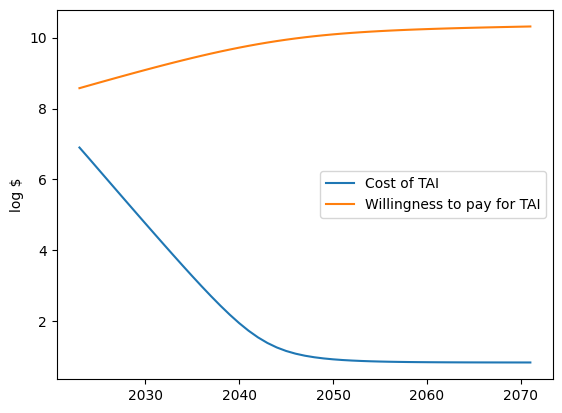

-
-
## SAMPLE RUN 9 ##
It takes 29.8 log FLOP (~631 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~742 million). This doubles every 2.8 years to a max of 0.04864% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.8 log FLOP (631 octillion) - log $ 11.5 to buy TAI (316 billion) vs. willingness to pay log $ 8.8 (696 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 29.7 log FLOP (507 octillion) - log $ 11.3 to buy TAI (188 billion) vs. willingness to pay log $ 8.9 (878 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

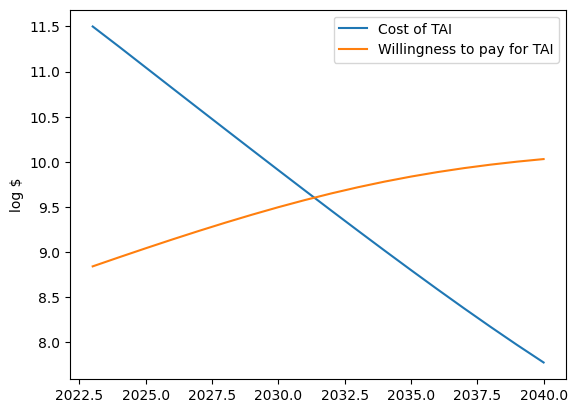

-
-
## SAMPLE RUN 10 ##
It takes 30.9 log FLOP (~8 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~750 million). This doubles every 3.1 years to a max of 0.058516% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 30.9 log FLOP (8 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 8.9 (710 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.4 to buy TAI (2 trillion) vs. willingness to pay log $ 8.9 (878 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.5)
Ye

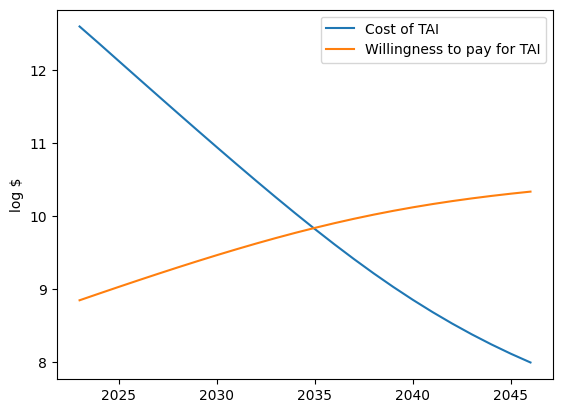

-
-
## SAMPLE RUN 11 ##
It takes 24.1 log FLOP (~1 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~139 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 24.1 log FLOP (1 septillion) - log $ 5.8 to buy TAI (631 thousand) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not

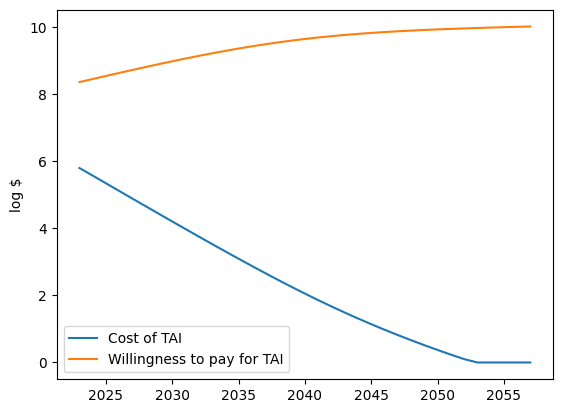

-
-
## SAMPLE RUN 12 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~395 million). This doubles every 1.7 years to a max of 0.206776% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.9 max log FLOP (781 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.6 (392 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.1 to buy TAI (12 billion) vs. willingness to pay log $ 8.8 (587 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 

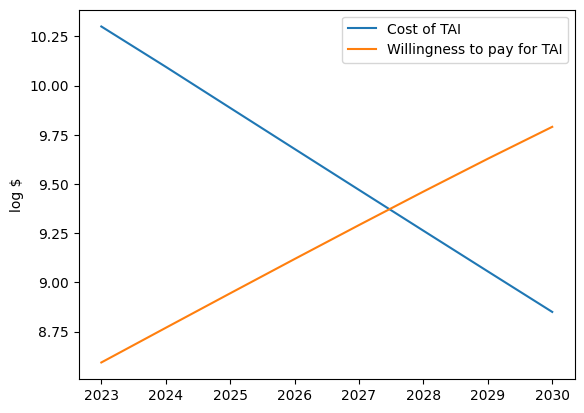

-
-
## SAMPLE RUN 13 ##
It takes 30.8 log FLOP (~6 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 2.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.2 to buy TAI (2 trillion) vs. willingness to pay log $ 8.6 (387 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
Y

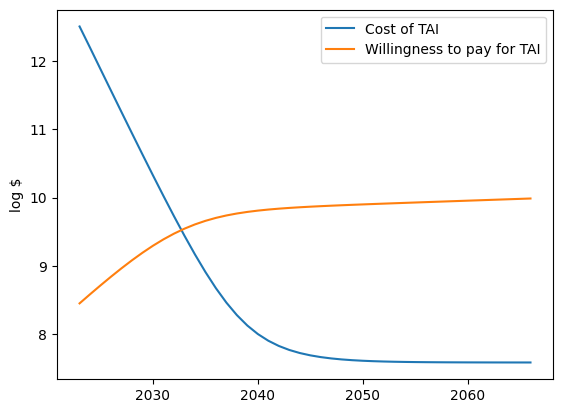

-
-
## SAMPLE RUN 14 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.7 to buy TAI (500 billion) vs. willingness to pay log $ 8.6 (446 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)


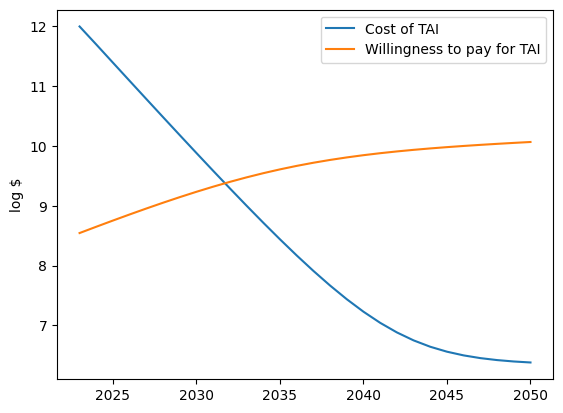

-
-
## SAMPLE RUN 15 ##
It takes 28.5 log FLOP (~32 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~107 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.2 to buy TAI (16 billion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (496 septillion) available - TAI takes 28.4 log FLOP (25 octillion) - log $ 10.0 to buy TAI (10 billion) vs. willingness to pay log $ 8.3 (187 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP:

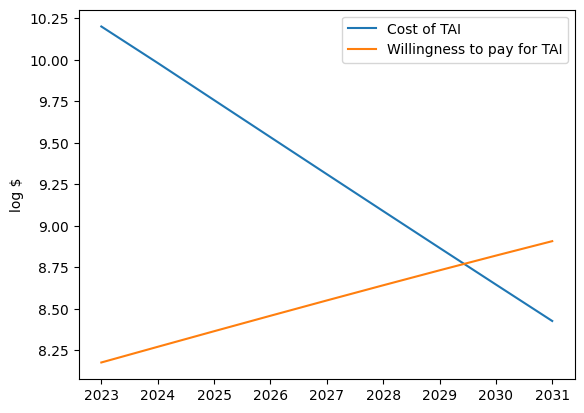

-
-
## SAMPLE RUN 16 ##
It takes 29.9 log FLOP (~794 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 1.0 years until 2025, and then doubles every 1.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.9 max log FLOP (851 septillion) available - TAI takes 29.9 log FLOP (794 octillion) - log $ 11.6 to buy TAI (398 billion) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 29.8 log FLOP (638 octillion) - log $ 11.4 to buy TAI (232 billion) vs. willingness to pay log $ 8.9 (803 million) - 18.4 log FLOP p

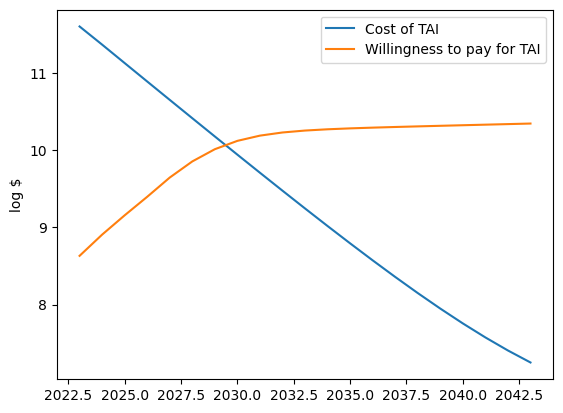

-
-
## SAMPLE RUN 17 ##
It takes 24.4 log FLOP (~3 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~25 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 2.3 years to a max of 0.030349% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.3 max log FLOP (194 septillion) available - TAI takes 24.4 log FLOP (3 septillion) - log $ 6.1 to buy TAI (1 million) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not oc

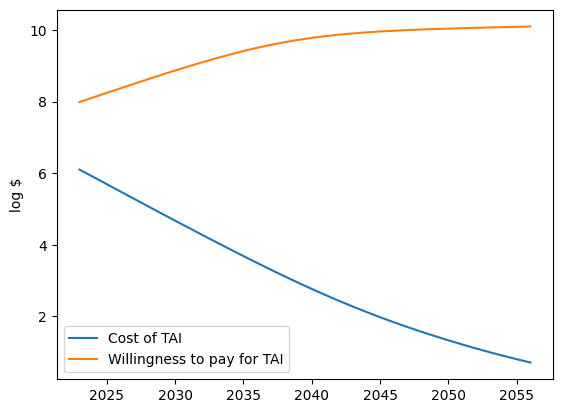

-
-
## SAMPLE RUN 18 ##
It takes 35.9 log FLOP (~794 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~373 million). This doubles every 3.3 years to a max of 0.025544% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 26.8 max log FLOP (699 septillion) available - TAI takes 35.9 log FLOP (794 decillion) - log $ 17.6 to buy TAI (398 quadrillion) vs. willingness to pay log $ 8.5 (351 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 35.7 log FLOP (501 decillion) - log $ 17.2 to buy TAI (171 quadrillion) vs. willingness to pay log $ 8.6 (428 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2

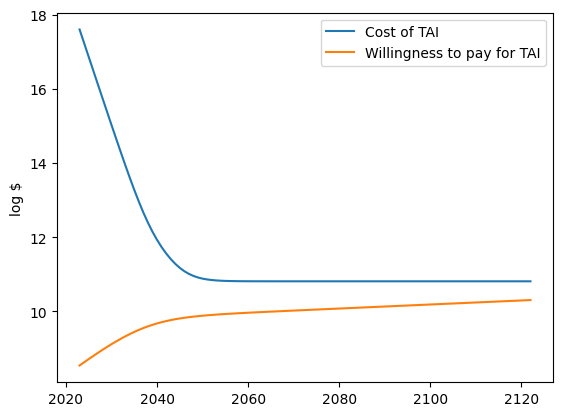

-
-
## SAMPLE RUN 19 ##
It takes 27.6 log FLOP (~4 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.0 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 4.0 years to a max of 0.053254% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.4 max log FLOP (246 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.1 (123 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.8 max log FLOP (594 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 8.9 to buy TAI (790 million) vs. willingness to pay log $ 8.2 (147 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 26.9)

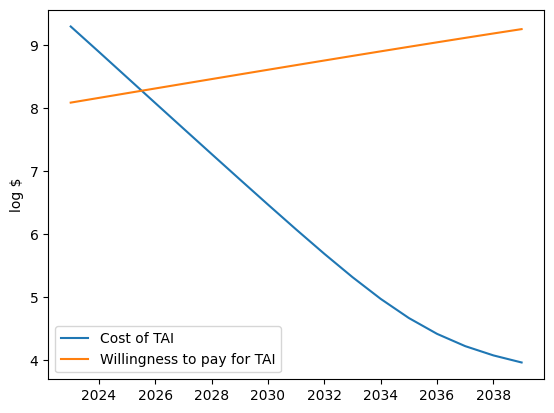

-
-
## SAMPLE RUN 20 ##
It takes 26.4 log FLOP (~251 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~66 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 1.7 years to a max of 0.155245% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.4 max log FLOP (249 septillion) available - TAI takes 26.4 log FLOP (251 septillion) - log $ 8.1 to buy TAI (126 million) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.7 max log FLOP (533 septillion) available - TAI takes 26.3 log FLOP (202 septillion) - log $ 7.9 to buy TAI (71 million) vs. willingness to pay log $ 8.3 (188 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-log

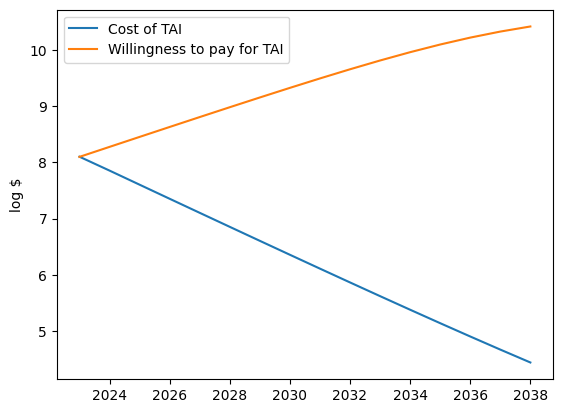

-
-
## SAMPLE RUN 21 ##
It takes 37.4 log FLOP (~25 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~493 million). This doubles every 1.0 years to a max of 0.139845% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.0 max log FLOP (970 septillion) available - TAI takes 37.4 log FLOP (25 thousand decillion) - log $ 19.1 to buy TAI (13 quintillion) vs. willingness to pay log $ 8.7 (486 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 37.1 log FLOP (13 thousand decillion) - log $ 18.7 to buy TAI (5 quintillion) vs. willingness to pay log $ 9.0 (952 million) - 18.4 log FLOP per $ (3 quint

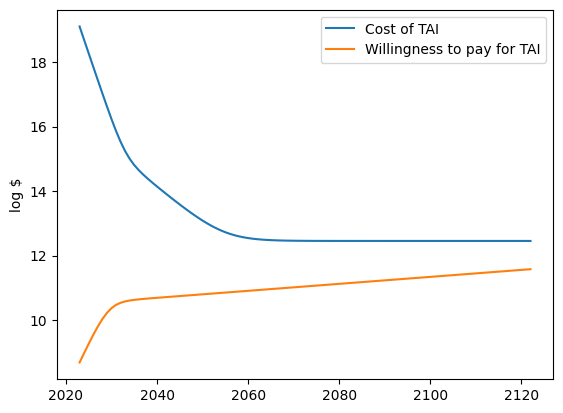

-
-
## SAMPLE RUN 22 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 20.7 log FLOP (~513 quintillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~485 million). This doubles every 1.5 years to a max of 0.06644% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.0 max log FLOP (935 septillion) available - TAI takes 26.0 log FLOP (100 septillion) - log $ 7.7 to buy TAI (50 million) vs. willingness to pay log $ 8.7 (470 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 7 years)
-- data p_n

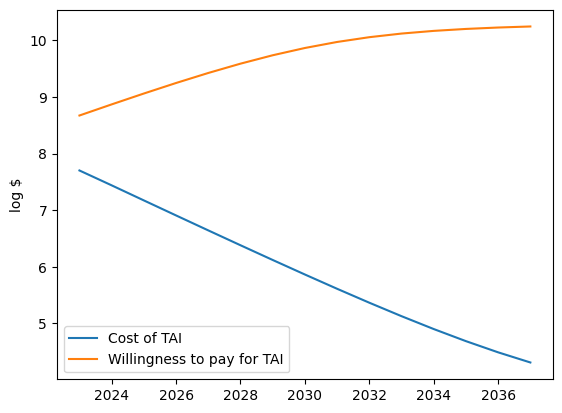

-
-
## SAMPLE RUN 23 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~246 million). This doubles every 2.6 years to a max of 0.047994% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.7 max log FLOP (479 septillion) available - TAI takes 26.0 log FLOP (100 septillion) - log $ 7.7 to buy TAI (50 million) vs. willingness to pay log $ 8.4 (240 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 9 years)
-- data p_nons

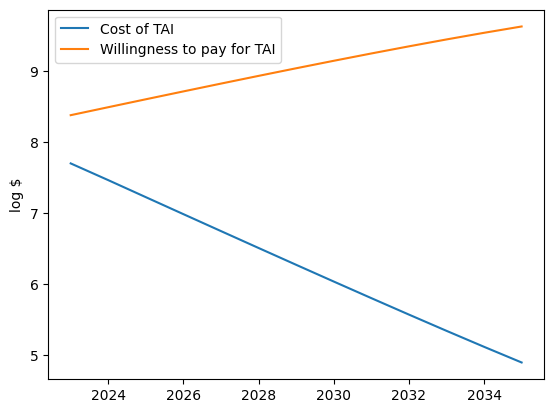

-
-
## SAMPLE RUN 24 ##
It takes 45.2 log FLOP (~2 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~22 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~625 million). This doubles every 1.3 years to a max of 0.29898% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 45.2 log FLOP (2 trillion decillion) - log $ 26.9 to buy TAI (794 septillion) vs. willingness to pay log $ 8.8 (620 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 44.9 log FLOP (792 billion decillion) - log $ 26.5 to buy TAI (311 septillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion) 

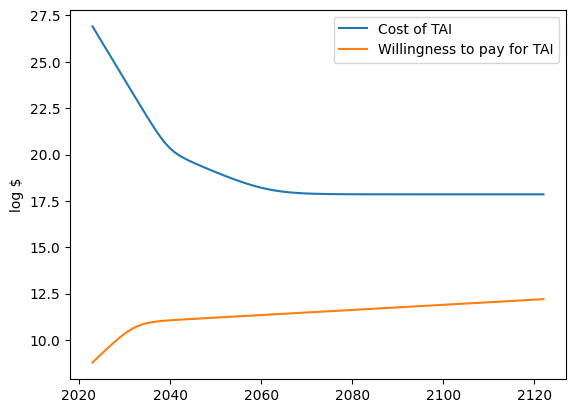

-
-
## SAMPLE RUN 25 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (60 billion) vs. willingness to pay log $ 8.7 (555 million) - 18.4 log FLOP pe

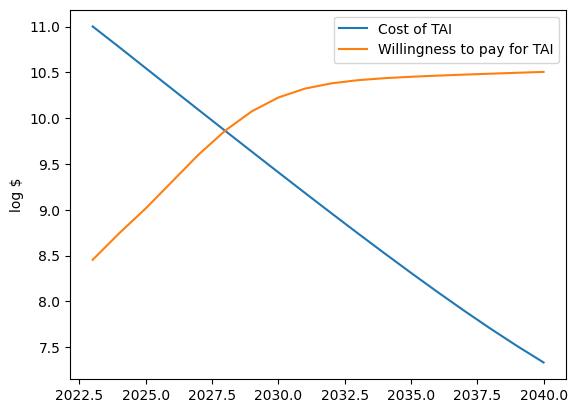

-
-
## SAMPLE RUN 26 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~104 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.6 (432 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.1)
Y

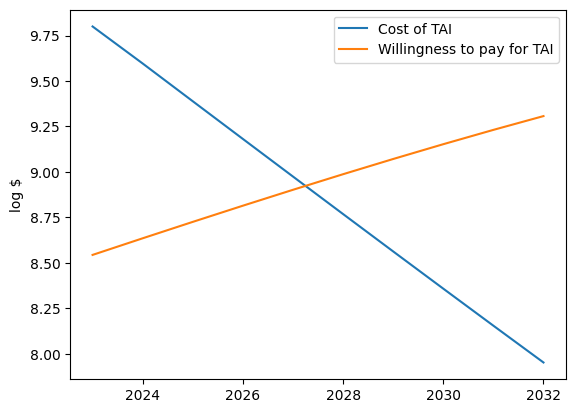

-
-
## SAMPLE RUN 27 ##
It takes 35.4 log FLOP (~251 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 4.6 years to a max of 0.027765% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.6 max log FLOP (375 septillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.1 to buy TAI (126 quadrillion) vs. willingness to pay log $ 8.3 (188 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (565 septillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.8 to buy TAI (61 quadrillion) vs. willingness to pay log $ 8.3 (217 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 

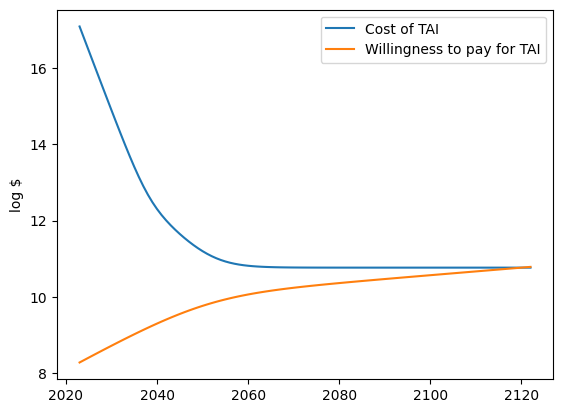

-
-
## SAMPLE RUN 28 ##
It takes 32.3 log FLOP (~200 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~726 million). This doubles every 2.1 years to a max of 0.036426% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 32.3 log FLOP (200 nonillion) - log $ 14.0 to buy TAI (100 trillion) vs. willingness to pay log $ 8.8 (668 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 32.2 log FLOP (143 nonillion) - log $ 13.7 to buy TAI (52 trillion) vs. willingness to pay log $ 9.0 (898 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLO

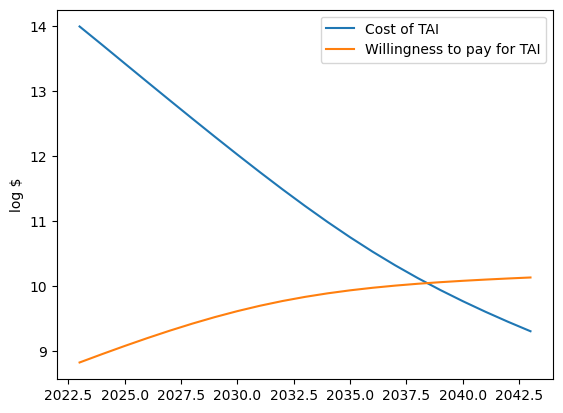

-
-
## SAMPLE RUN 29 ##
It takes 46.2 log FLOP (~16 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~587 million). This doubles every 1.6 years to a max of 0.03708% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 46.2 log FLOP (16 trillion decillion) - log $ 27.9 to buy TAI (8 octillion) vs. willingness to pay log $ 8.7 (550 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 45.9 log FLOP (8 trillion decillion) - log $ 27.5 to buy TAI (3 octillion) vs. willingness to pay log $ 8.9 (829 million) - 18.4 log FLOP per $ (3 quintillion) (

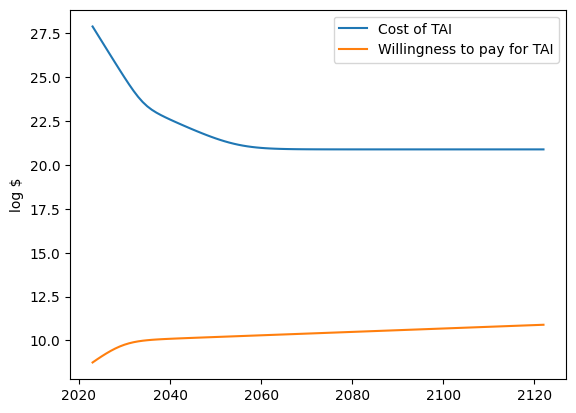

-
-
## SAMPLE RUN 30 ##
It takes 32.0 log FLOP (~100 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 1.9 years to a max of 0.695746% of GDP. GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 32.0 log FLOP (100 nonillion) - log $ 13.7 to buy TAI (50 trillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 31.9 log FLOP (72 nonillion) - log $ 13.4 to buy TAI (28 trillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.9)


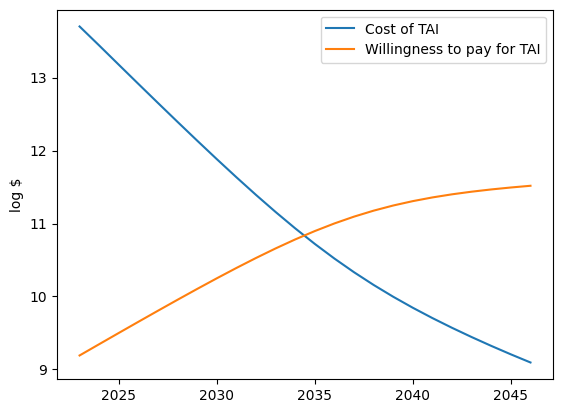

-
-
## SAMPLE RUN 31 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~737 million). This doubles every 3.7 years to a max of 0.044507% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.8 (688 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.9 (819 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 20

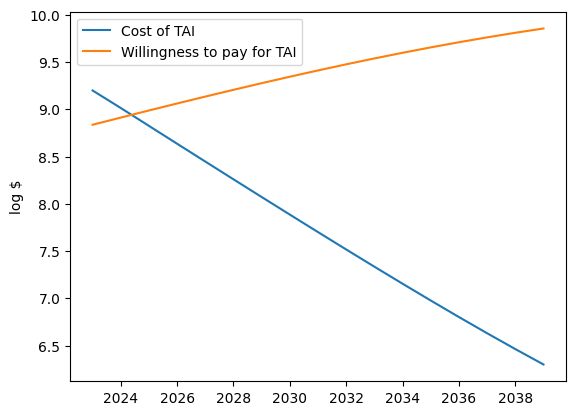

-
-
## SAMPLE RUN 32 ##
It takes 27.8 log FLOP (~6 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 3.6 years to a max of 0.02563% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.9 (882 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2025 -

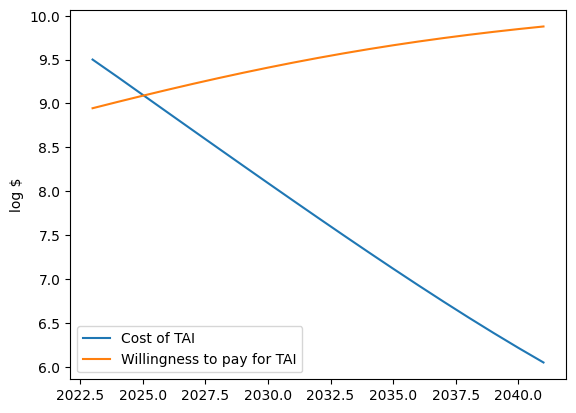

-
-
## SAMPLE RUN 33 ##
It takes 32.6 log FLOP (~398 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 3.3 years to a max of 0.223469% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.8 max log FLOP (623 septillion) available - TAI takes 32.6 log FLOP (398 nonillion) - log $ 14.3 to buy TAI (200 trillion) vs. willingness to pay log $ 8.5 (312 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (938 septillion) available - TAI takes 32.5 log FLOP (285 nonillion) - log $ 14.1 to buy TAI (117 trillion) vs. willingness to pay log $ 8.6 (385 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023

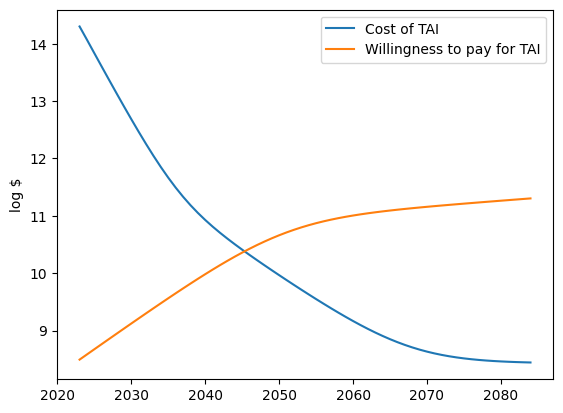

-
-
## SAMPLE RUN 34 ##
It takes 32.6 log FLOP (~398 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 2.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 32.6 log FLOP (398 nonillion) - log $ 14.3 to buy TAI (200 trillion) vs. willingness to pay log $ 8.9 (742 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 32.5 log FLOP (285 nonillion) - log $ 14.0 to buy TAI (108 trillion) vs. willingness to pay log $ 9.0 (949 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

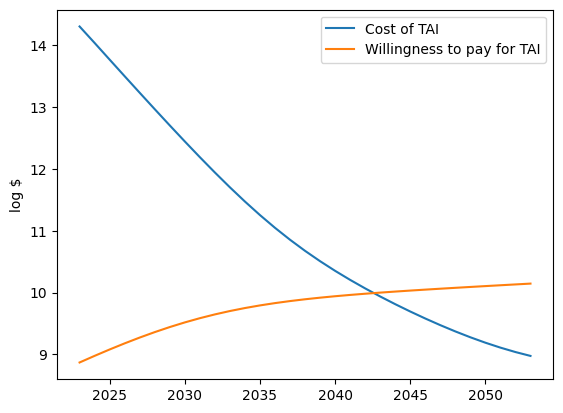

-
-
## SAMPLE RUN 35 ##
It takes 37.0 log FLOP (~10 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~57 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~382 million). This doubles every 3.3 years to a max of 0.0402% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.9 max log FLOP (731 septillion) available - TAI takes 37.0 log FLOP (10 thousand decillion) - log $ 18.7 to buy TAI (5 quintillion) vs. willingness to pay log $ 8.6 (367 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 36.7 log FLOP (5 thousand decillion) - log $ 18.3 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.7 (449 million) - 18.4 log FLOP per $ (2 quintill

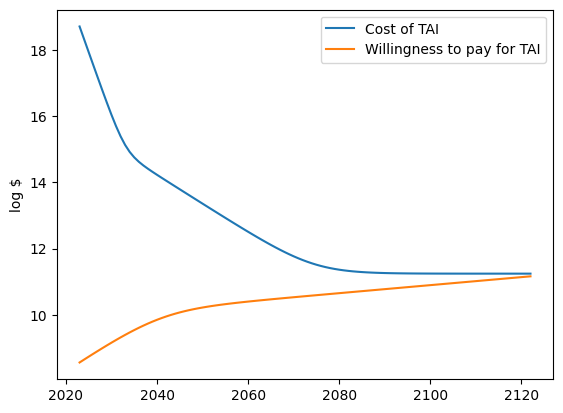

-
-
## SAMPLE RUN 36 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~194 million). This doubles every 4.9 years to a max of 0.029667% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.6 max log FLOP (376 septillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.3 (189 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.7 max log FLOP (558 septillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.8 to buy TAI (594 billion) vs. willingness to pay log $ 8.3 (216 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP:

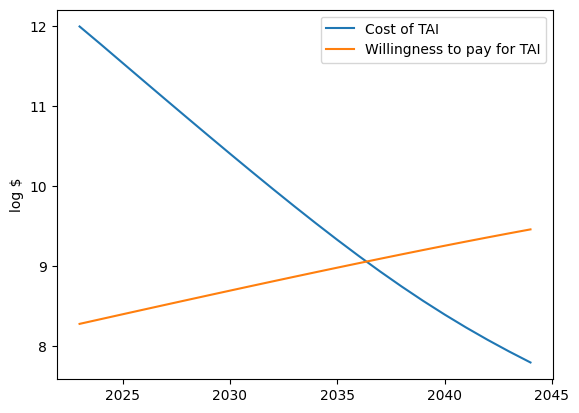

-
-
## SAMPLE RUN 37 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 3.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.8 max log FLOP (697 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.6 (427 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
Y

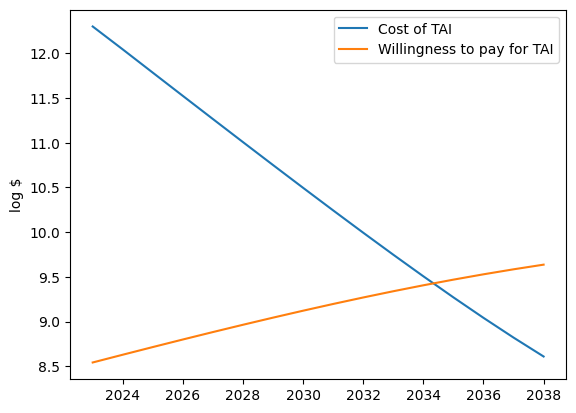

-
-
## SAMPLE RUN 38 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~56 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~307 million). This doubles every 2.8 years to a max of 0.046779% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.8 max log FLOP (596 septillion) available - TAI takes 26.0 log FLOP (100 septillion) - log $ 7.7 to buy TAI (50 million) vs. willingness to pay log $ 8.5 (299 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 5 years)
-- data p_non

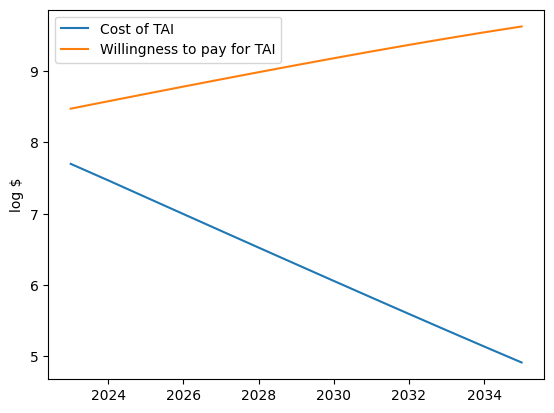

-
-
## SAMPLE RUN 39 ##
It takes 34.7 log FLOP (~50 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~315 million). This doubles every 2.5 years to a max of 0.337423% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.8 max log FLOP (625 septillion) available - TAI takes 34.7 log FLOP (50 decillion) - log $ 16.4 to buy TAI (25 quadrillion) vs. willingness to pay log $ 8.5 (314 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 34.5 log FLOP (32 decillion) - log $ 16.0 to buy TAI (10 quadrillion) vs. willingness to pay log $ 8.6 (414 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-lo

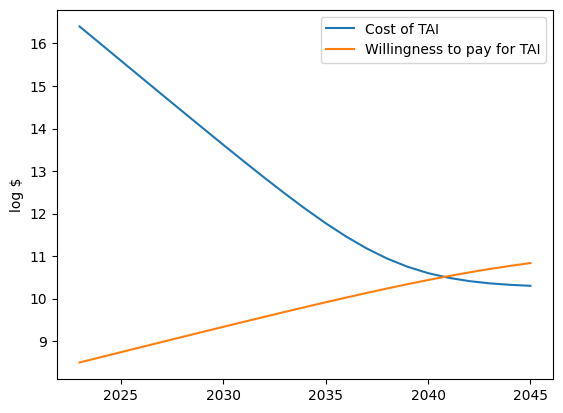

-
-
## SAMPLE RUN 40 ##
It takes 28.2 log FLOP (~16 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~31 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~198 million). This doubles every 3.4 years to a max of 0.091483% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.6 max log FLOP (391 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 8.3 (196 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (596 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.4 (240 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 2

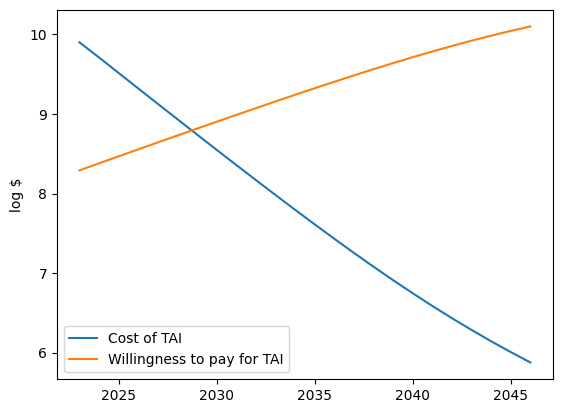

-
-
## SAMPLE RUN 41 ##
It takes 39.3 log FLOP (~2 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 20.8 log FLOP (~683 quintillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.6 max log FLOP (371 septillion) available - TAI takes 39.3 log FLOP (2 million decillion) - log $ 21.0 to buy TAI (1 sextillion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (709 septillion) available - TAI takes 39.0 log FLOP (998 thousand decillion) - log $ 20.6 to buy TAI (355 quintillion) vs. willingness to pay log $ 8.4 (253 million) - 18.4 log FLOP per $ (3 quintill

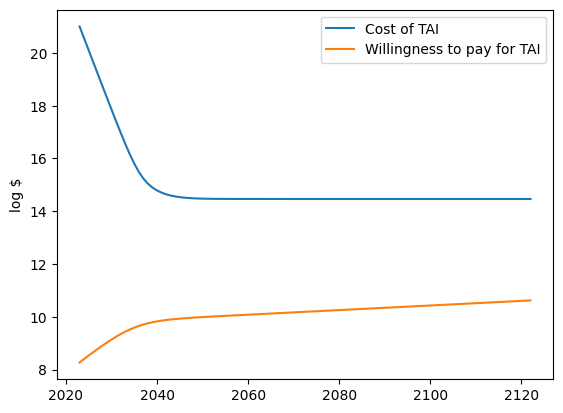

-
-
## SAMPLE RUN 42 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~148 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~195 million). This doubles every 1.8 years to a max of 0.034719% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.6 max log FLOP (379 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.3 (190 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (735 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (958 million) vs. willingness to pay log $ 8.4 (277 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.

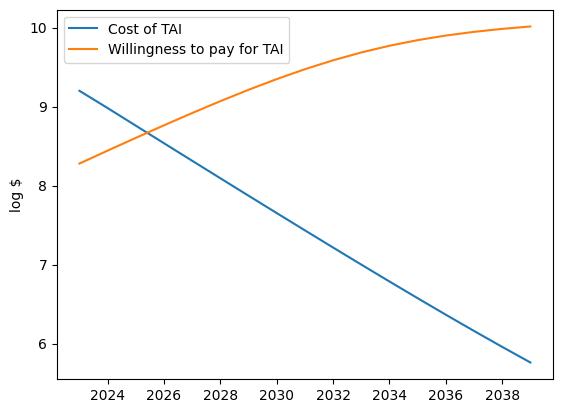

-
-
## SAMPLE RUN 43 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~306 million). This doubles every 1.7 years to a max of 0.039813% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.8 max log FLOP (590 septillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.8 to buy TAI (632 quadrillion) vs. willingness to pay log $ 8.5 (296 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.4 to buy TAI (255 quadrillion) vs. willingness to pay log $ 8.6 (438 million) - 18.4 log FLOP per $ (2 quintillion)

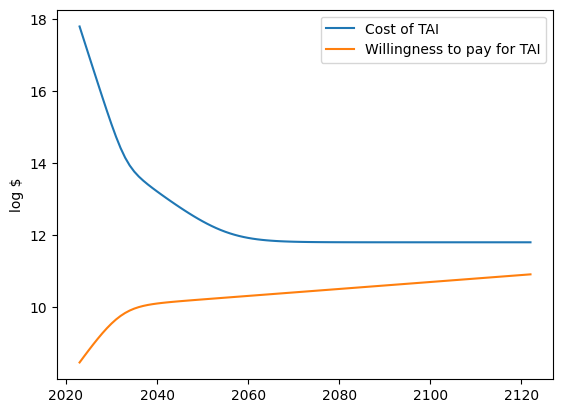

-
-
## SAMPLE RUN 44 ##
It takes 28.2 log FLOP (~16 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.005x per year.
---
Year: 2023 - 26.8 max log FLOP (697 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.7 (449 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
Ye

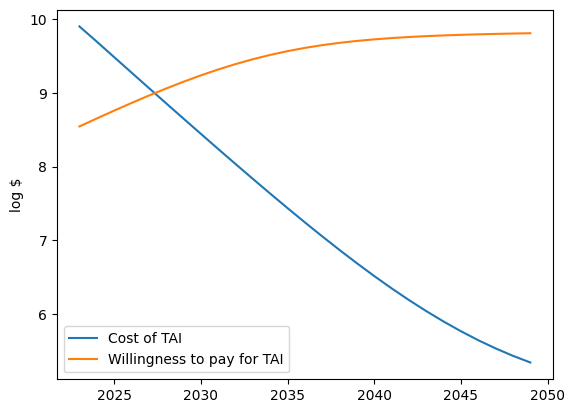

-
-
## SAMPLE RUN 45 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 3.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 8.2 to buy TAI (159 million) vs. willingness to pay log $ 8.9 (876 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years)
-- data p_nonscaling

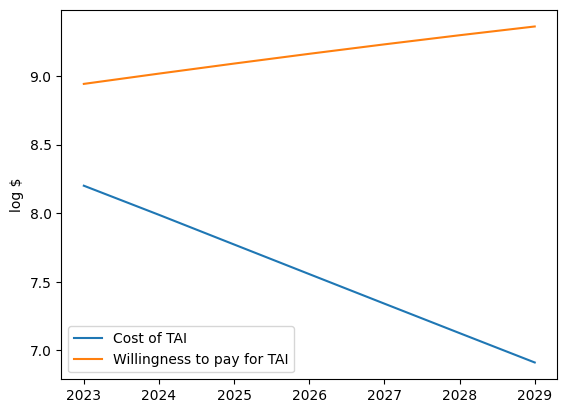

-
-
## SAMPLE RUN 46 ##
It takes 36.8 log FLOP (~6 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~473 million). This doubles every 1.3 years to a max of 0.037185% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.0 max log FLOP (895 septillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 18.5 to buy TAI (3 quintillion) vs. willingness to pay log $ 8.7 (449 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 18.1 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.9 (729 million) - 18.4 log FLOP per $ (3 quintill

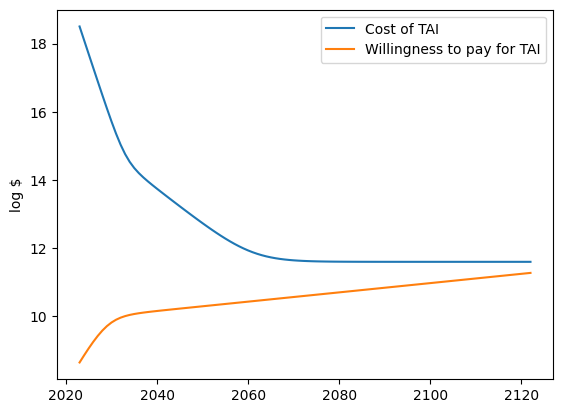

-
-
## SAMPLE RUN 47 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.4 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 2.9 years to a max of 0.183122% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.8 max log FLOP (621 septillion) available - TAI takes 38.8 log FLOP (631 thousand decillion) - log $ 20.5 to buy TAI (316 quintillion) vs. willingness to pay log $ 8.5 (312 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.0 to buy TAI (98 quintillion) vs. willingness to pay log $ 8.6 (394 million) - 18.5 log FLOP per $ (3 

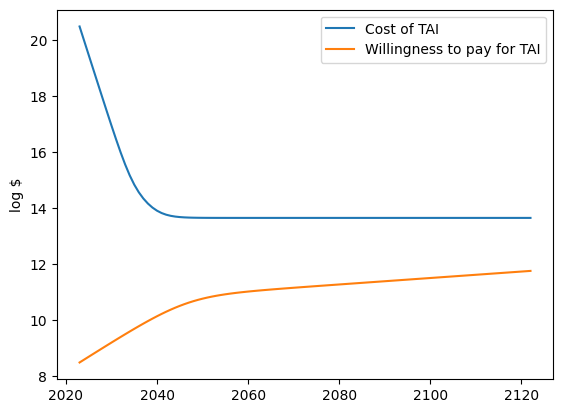

-
-
## SAMPLE RUN 48 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~251 million). This doubles every 3.4 years to a max of 0.423021% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.7 max log FLOP (498 septillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.9 to buy TAI (79 million) vs. willingness to pay log $ 8.4 (250 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 5 years)
-- data p_non

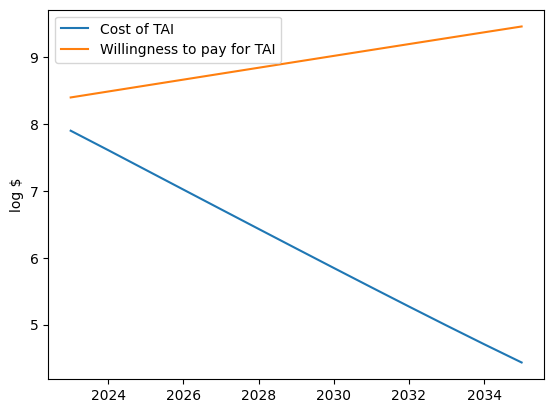

-
-
## SAMPLE RUN 49 ##
It takes 32.1 log FLOP (~126 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 32.1 log FLOP (126 nonillion) - log $ 13.8 to buy TAI (63 trillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 32.0 log FLOP (90 nonillion) - log $ 13.5 to buy TAI (31 trillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.7)
Yea

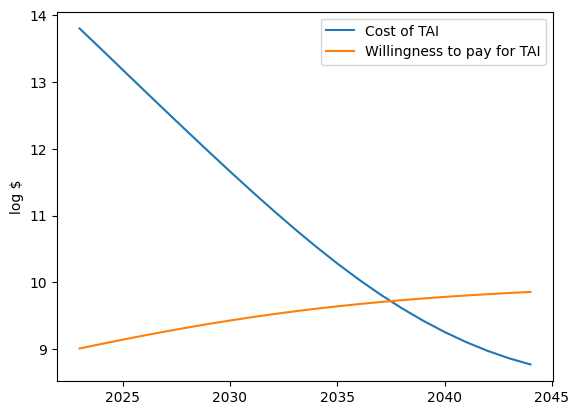

-
-
## SAMPLE RUN 50 ##
It takes 32.6 log FLOP (~398 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 3.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 32.6 log FLOP (398 nonillion) - log $ 14.3 to buy TAI (200 trillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (937 septillion) available - TAI takes 32.5 log FLOP (285 nonillion) - log $ 14.0 to buy TAI (103 trillion) vs. willingness to pay log $ 8.5 (337 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logF

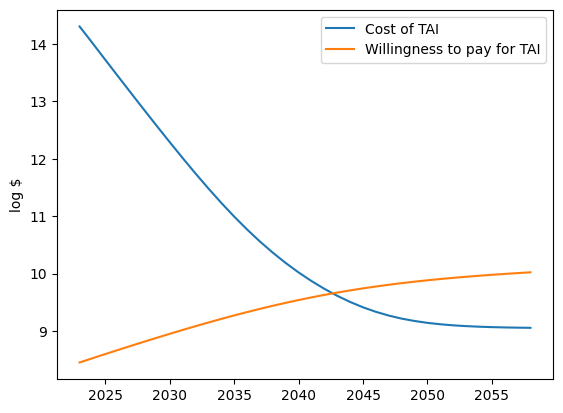

-
-
## SAMPLE RUN 51 ##
It takes 25.1 log FLOP (~13 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~249 million). This doubles every 3.8 years to a max of 0.112768% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.7 max log FLOP (492 septillion) available - TAI takes 25.1 log FLOP (13 septillion) - log $ 6.8 to buy TAI (6 million) vs. willingness to pay log $ 8.4 (246 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 9 years (total delay 9 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 10 years)
-- data p_nonsc

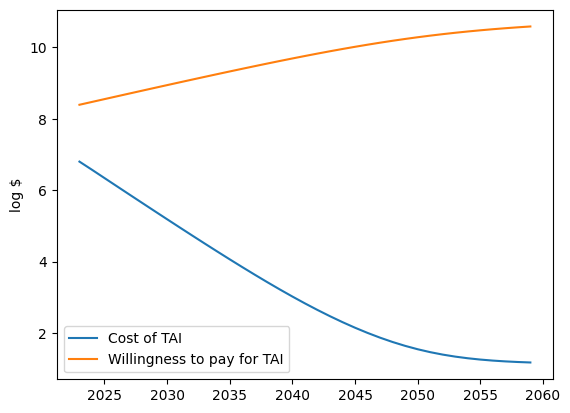

-
-
## SAMPLE RUN 52 ##
It takes 27.4 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 4.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.036x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 26.9 max log FLOP (839 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 8.9 to buy TAI (807 million) vs. willingness to pay log $ 8.5 (335 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Y

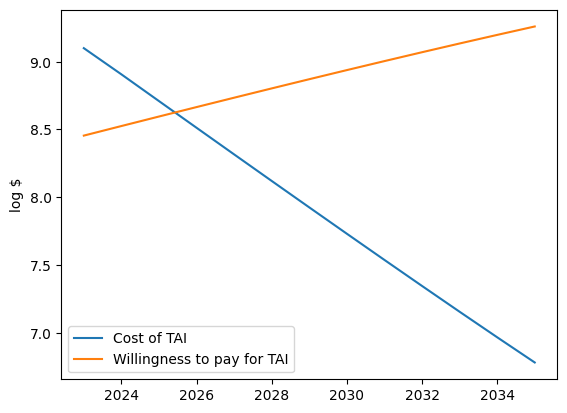

-
-
## SAMPLE RUN 53 ##
It takes 26.7 log FLOP (~501 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~891 quintillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 1.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.8 max log FLOP (567 septillion) available - TAI takes 26.7 log FLOP (501 septillion) - log $ 8.4 to buy TAI (252 million) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 6 years)
-- data p_no

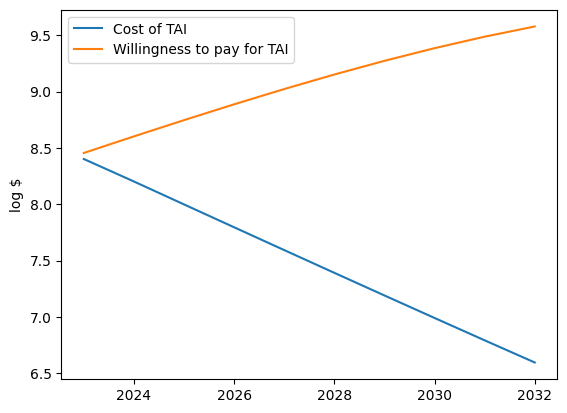

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)